# **Context**

The Titanic dataset is a well-known dataset used in machine learning and predictive modeling. It contains information about passengers aboard the RMS Titanic during its maiden voyage, including whether they survived or not.

Here's a brief description of the features:

* PassengerId: A unique identifier for each passenger.
* Survived: Indicates whether the passenger survived or not (0 = No, 1 = Yes).
* Pclass: Ticket class of the passenger (1 = 1st, 2 = 2nd, 3 = 3rd).
* Name: Name of the passenger.
* Sex: Gender of the passenger.
* Age: Age of the passenger.
* SibSp: Number of siblings or spouses aboard the Titanic.
* Parch: Number of parents or children aboard the Titanic.
* Ticket: Ticket number.
* Fare: Fare paid for the ticket.
* Cabin: Cabin number of the passenger.
* Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

The **main objective** when working with this dataset is to predict the survival of passengers. 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set() 

#  **Quick look througt the data**

In [2]:
# Reading the training data from the 'train.csv' file into a DataFrame 'titanic_train'
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')

# Reading the testing data from the 'test.csv' file into a DataFrame 'titanic_test'
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')

# Concatenating both training and testing DataFrames into a single DataFrame 'titanic_data'
# Setting 'ignore_index=True' to ignore the existing indices and create a new index
# Setting 'sort=False' to avoid sorting based on the index
titanic_data = pd.concat([titanic_train, titanic_test], ignore_index=True, sort=False)

# Displaying the first few rows of the concatenated DataFrame 'titanic_data'
titanic_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Checking for duplicates**

In [3]:
duplicates = titanic_data.duplicated().sum()
duplicates

0

There ara no duplicates in "titanic_data".

**Checking for data format and configure the output**

In [4]:
titanic_data.dtypes

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
titanic_data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

In fact, this dataset contains only two numerical predictors - 'Age' and 'Fare'. Let's look at their descriptive statistics.

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)

# Displaying descriptive statistics for numerical columns in the DataFrame 'titanic_data'
titanic_data[['Age', 'Fare']].describe()

,Age,Fare
count,1046.00,1308.00
mean,29.88,33.30
std,14.41,51.76
min,0.17,0.00
25%,21.00,7.90
50%,28.00,14.45
75%,39.00,31.27
max,80.00,512.33


Here we can see that the youngest Titanic passenger was not even a year old, and the oldest was 80 years old, and also not everyone paid for the fare.

For convenience, let's create their categorical counterparts.

In [7]:
# Creating age categories
titanic_data['Age_cat'] = pd.cut(
    x=titanic_data['Age'],
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80],
    labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
)

In [8]:
# Creating fare categories based on 'Fare' column values
titanic_data['Fare_cat'] = pd.cut(
    titanic_data['Fare'],  
    bins=[-np.inf, 7.90, 14.45, 31.28, 120, np.inf],  
    labels=['Very-Low', 'Low', 'Mid', 'High', 'Very-High']
)

Also, the columns 'Parch' and 'SibSp' can be combined into the variable 'Family'.

In [9]:
titanic_data['Family'] = titanic_data['Parch'] + titanic_data['SibSp']

To avoid confusion for now, let's convert 'int' categorical data to string format.

In [10]:
columns_to_convert = ['Survived', 'Age_cat', 'Fare_cat']
titanic_data[columns_to_convert] = titanic_data[columns_to_convert].applymap(lambda x: str(x) if pd.notnull(x) else x)
titanic_data[['Pclass', 'SibSp', 'Parch', 'Family']] = titanic_data[['Pclass', 'SibSp', 'Parch', 'Family']].astype('str')

The 'Name' variable in its raw form might not hold direct significance, yet from it, we can extract honorific titles (such as Mr, Miss, Mrs) that could be valuable for classification purposes.

In [11]:
# Extracting salutations (titles) from the 'Name' column
titanic_data['Salutation'] = titanic_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

# Replacing certain titles with 'Other' in the 'Salutation' column
titanic_data['Salutation'].replace(
    ['Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
    'Other',
    inplace=True
)

# Replacing specific titles with their corresponding common titles in the 'Salutation' column
titanic_data['Salutation'].replace(
    {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'},
    inplace=True
)

In [12]:
titanic_data['Survived'] = titanic_data['Survived'].replace('\.0', '', regex=True)
fitures = titanic_data[['Survived', 'Pclass', 'Fare_cat', 'Salutation', 'Sex', 'Age_cat', 'Family', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']]

fitures.head()

,Survived,Pclass,Fare_cat,Salutation,Sex,Age_cat,Family,SibSp,Parch,Ticket,Cabin,Embarked
0,0,3,Very-Low,Mr,male,20-30,1,1,0,A/5 21171,NaN,S
1,1,1,High,Mrs,female,30-40,1,1,0,PC 17599,C85,C
2,1,3,Low,Miss,female,20-30,0,0,0,STON/O2. 3101282,NaN,S
3,1,1,High,Mrs,female,30-40,1,1,0,113803,C123,S
4,0,3,Low,Mr,male,30-40,0,0,0,373450,NaN,S


In [13]:
# Displaying object type statistics for 'fitures'

fitures.describe(include=['O'])

,Survived,Pclass,Fare_cat,Salutation,Sex,Age_cat,Family,SibSp,Parch,Ticket,Cabin,Embarked
count,891,1309,1308,1309,1309,1046,1309,1309,1309,1309,295,1307
unique,2,3,5,5,2,8,9,7,8,929,186,3
top,0,3,Mid,Mr,male,20-30,0,0,0,CA. 2343,C23 C25 C27,S
freq,549,709,338,757,843,361,790,891,1002,11,6,914


Looking at this table we can draw the following conclusions:

1. More people died in the crash than survived.
2. More than half of the passengers were traveling third class.
3. Men were predominant on board.
4. There were noticeably fewer people traveling with relatives than singles.
5. More passengers boarded the ship at Southampton port than at other ports.
6. Ticket and cabin numbers were duplicated.


**Checking for missing values**

In [14]:
# Check the count of NaN values in each column
fitures.isnull().sum()

Survived       418
Pclass           0
Fare_cat         1
Salutation       0
Sex              0
Age_cat        263
Family           0
SibSp            0
Parch            0
Ticket           0
Cabin         1014
Embarked         2
dtype: int64

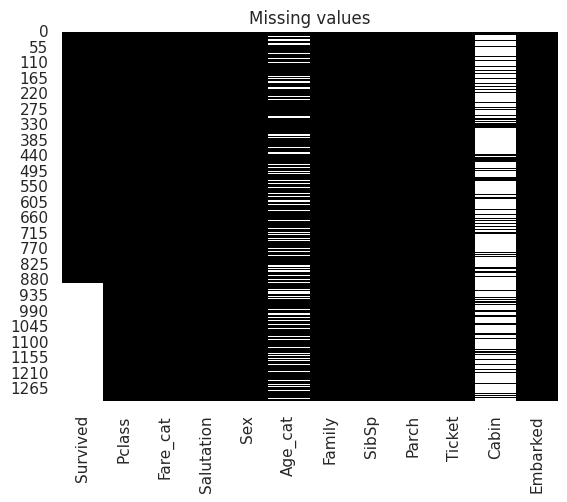

In [15]:
sns.heatmap(fitures.isnull(), cmap='binary_r', cbar=False).set_title("Missing values");

Columns 'Survived', 'Age_cat', 'Fare_cat', 'Cabin', and 'Embarked' contain missing values.

NaNs in 'Survived' column arose from merging the 'titanic_train' and 'titanic_test' datasets because the latter lacked the corresponding column. The objective of this project is to fill in these gaps.

Columns 'Fare_cat' and 'Embarked' contain a very small number of missing values, so I will replace them with the median and mode, respectively.

I won't utilize the 'Cabin' column for model training, so I don't plan to restore entries here.

To fill in the missing values in the 'Age_cat' column, I will train an auxiliary model.

In [16]:
titanic_data.Embarked.fillna(titanic_data.Embarked.mode()[0], inplace = True)
titanic_data.Fare_cat.fillna(titanic_data.Fare_cat.mode()[0], inplace = True)

Before training the models, let's analyze the features in more detail.

# **Features**

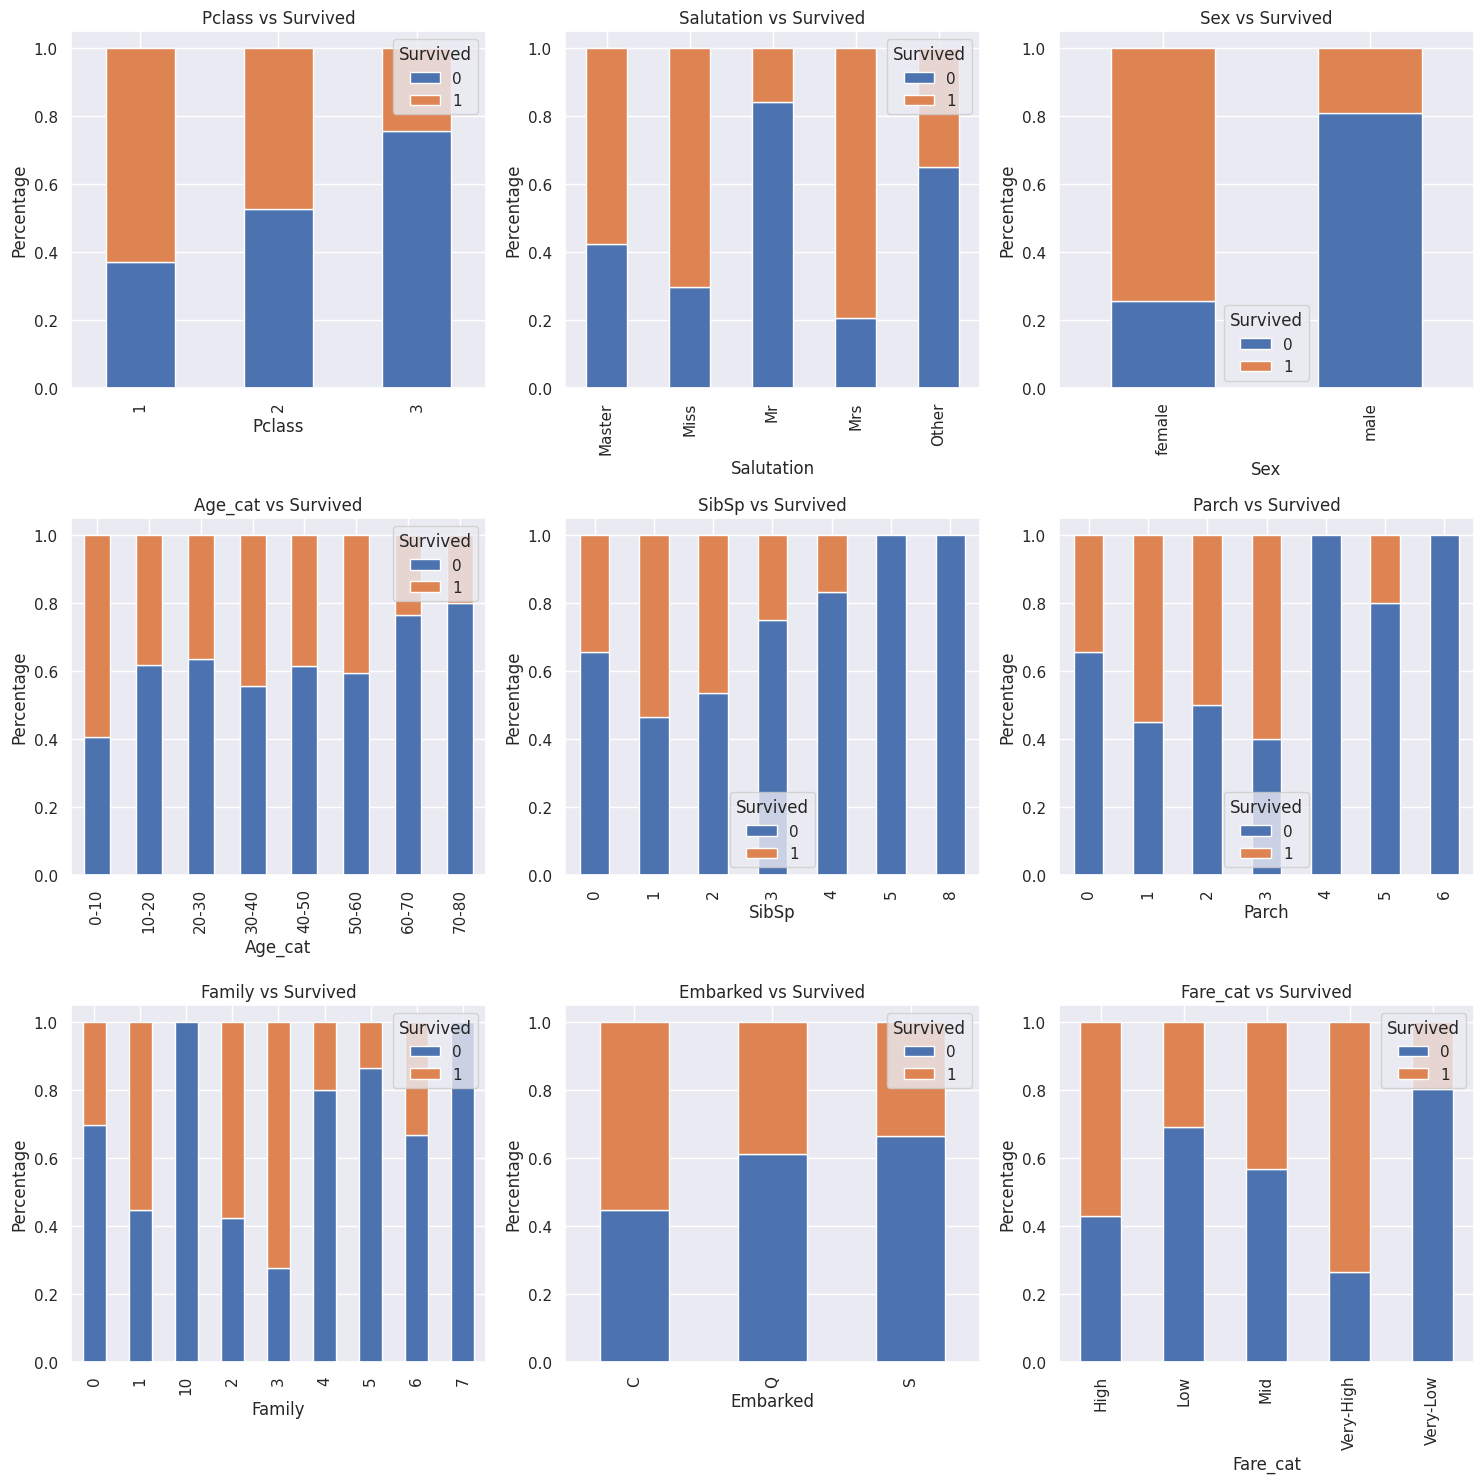

In [17]:
def crosstab_bar(df, x, y, ax=None):
    tab = pd.crosstab(df[x], df[y])
    tab.div(tab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel('Percentage')
    ax.set_title(f'{x} vs {y}')

columns = ['Pclass', 'Salutation', 'Sex', 'Age_cat', 'SibSp', 'Parch', 'Family', 'Embarked', 'Fare_cat']

fig, axes = plt.subplots(3, 3, figsize=(15, 15)) 

for i, col in enumerate(columns):
    crosstab_bar(fitures, col, 'Survived', ax=axes[i // 3, i % 3])

plt.tight_layout()
plt.show()


# **Feature Extraction**

Let's introduce numerical labels for all categorical variables.

In [18]:
from sklearn.preprocessing import LabelEncoder

# Encoding 'Salutation' column and creating a new 'salutation_labels' column
titanic_data['salutation_labels'] = LabelEncoder().fit_transform(titanic_data['Salutation'])

# Encoding 'Embarked' column and creating a new 'embarked_labels' column
titanic_data['embarked_labels'] = LabelEncoder().fit_transform(titanic_data['Embarked'])

# Encoding 'Fare_cat' column and creating a new 'fare_labels' column
titanic_data['fare_labels'] = LabelEncoder().fit_transform(titanic_data['Fare_cat'])

In [19]:
# Mapping age categories to numerical labels and creating a new 'age_labels' column
titanic_data['age_labels'] = titanic_data['Age_cat'].map({
    '0-10': 0, '10-20': 1, '20-30': 2, '30-40': 3,
    '40-50': 4, '50-60': 5, '60-70': 6, '70-80': 7
})

In [20]:
# Creating dummy variables for the 'Sex' column and assigning prefix 'is'
dummy_df = pd.get_dummies(titanic_data['Sex'], prefix='is', dtype='int')

# Concatenating the original DataFrame with the 'is_male' dummy variable
titanic_data = pd.concat([titanic_data, dummy_df['is_male']], axis=1)

In [21]:
# Columns to be dropped from the dataset
drop_cols = ['Survived', 'Name', 'PassengerId', 'SibSp', 'Parch', 'Sex', 'Age', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_cat', 'Fare_cat', 'Salutation']

# Creating a DataFrame of features for the classifier by dropping specified columns
clf_features = titanic_data.drop(drop_cols, axis=1)

# Displaying the resulting DataFrame containing features for the classifier
clf_features


,Pclass,Family,salutation_labels,embarked_labels,fare_labels,age_labels,is_male
0,3,1,2,2,4,2.00,1
1,1,1,3,0,0,3.00,0
2,3,0,1,2,1,2.00,0
3,1,1,3,2,0,3.00,0
4,3,0,2,2,1,3.00,1
...,...,...,...,...,...,...,...
1304,3,0,2,2,1,NaN,1
1305,1,0,4,0,0,3.00,0
1306,3,0,2,2,4,3.00,1
1307,3,0,2,2,1,NaN,1


In [22]:
clf_features[['Pclass', 'Family']] = clf_features[['Pclass', 'Family']].astype('int')

In [23]:
clf_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pclass             1309 non-null   int64  
 1   Family             1309 non-null   int64  
 2   salutation_labels  1309 non-null   int64  
 3   embarked_labels    1309 non-null   int64  
 4   fare_labels        1309 non-null   int64  
 5   age_labels         1046 non-null   float64
 6   is_male            1309 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 71.7 KB


"Let's train an auxiliary model to impute missing values in the 'Age_cat' column.

In [25]:
# Check for NaN values in 'age_labels' column
missing_mask = clf_features['age_labels'].isna()

# Filtering rows with NaN values in 'age_labels' column and dropping the column
X_missing = clf_features[missing_mask].drop('age_labels', axis=1)

# Filtering rows without NaN values in 'age_labels' column and dropping the column
X = clf_features[~missing_mask].drop('age_labels', axis=1)

# Extracting the target variable 'age_labels' for rows without NaN values in 'age_labels' column
y = clf_features.age_labels[~clf_features.age_labels.isna()]

In [26]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets (X_train, X_test, y_train, y_test)
# The test_size parameter defines the proportion of the dataset to include in the test split
# random_state is used for reproducibility to obtain the same split each time the code is run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Initializing a Random Forest Classifier with a specified random_state
rfc = RandomForestClassifier(random_state=42)

# Defining the parameter distribution for hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=1000, num=45)],
    'max_depth': [int(x) for x in np.linspace(start=5, stop=50, num=35)],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'max_features': ['log2', 'sqrt', None],
    'bootstrap': [True, False]
}

# Initializing RandomizedSearchCV to search through the parameter space
rs = RandomizedSearchCV(
    estimator=rfc, 
    param_distributions=param_dist, 
    n_iter=100,  # Number of parameter settings that are sampled
    cv=3,  # Number of cross-validation folds
    verbose=1,  # Controls verbosity
    n_jobs=-1,  # Number of jobs to run in parallel (-1 uses all processors)
    random_state=42  # Setting a fixed random_state for reproducibility
)

# Fitting the RandomizedSearchCV to the training data to find the best parameters
rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 10, 11, 12,
                                                      14, 15, 16, 18, 19, 20,
                                                      22, 23, 24, 26, 27, 28,
                                                      30, 31, 32, 34, 35, 36,
                                                      38, 39, 40, 42, 43, ...],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [2, 5, 8, 12, 15,
                                                             19, 22, 26, 29, 32,
                                                             36, 39, 43, 46,
                                                             50],
                                        'min_samples_split': [2, 5, 8, 12, 15,
                                                              19, 22, 26, 29,
                                                              32, 36, 39, 43,
                                                              46, 50],
                                        'n_estimators': [50, 71, 93, 114, 136,
                                                         157, 179, 201, 222,
                                                         244, 265, 287, 309,
                                                         330, 352, 373, 395,
                                                         417, 438, 460, 481,
                                                         503, 525, 546, 568,
                                                         589, 611, 632, 654,
                                                         676, ...]},
                   random_state=42, verbose=1)

When using parameters n_iter = 100 and cv = 3, we created 300 RF models by randomly selecting combinations of the hyperparameters mentioned above. To determine the range of values to continue the search, we can easily create a DataFrame containing the results of the RandomizedSearchCV algorithm.

In [67]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head()

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,265,15,8,sqrt,35,False,0.42,1
1,352,2,12,None,10,False,0.42,2
2,481,26,12,sqrt,22,False,0.42,3
3,136,19,2,sqrt,43,False,0.42,4
4,956,12,8,sqrt,46,True,0.42,5


Now let's create bar charts where the values of hyperparameters are on the X-axis and the average values shown by the models are on the Y-axis. This will help understand which hyperparameter values, on average, perform the best.

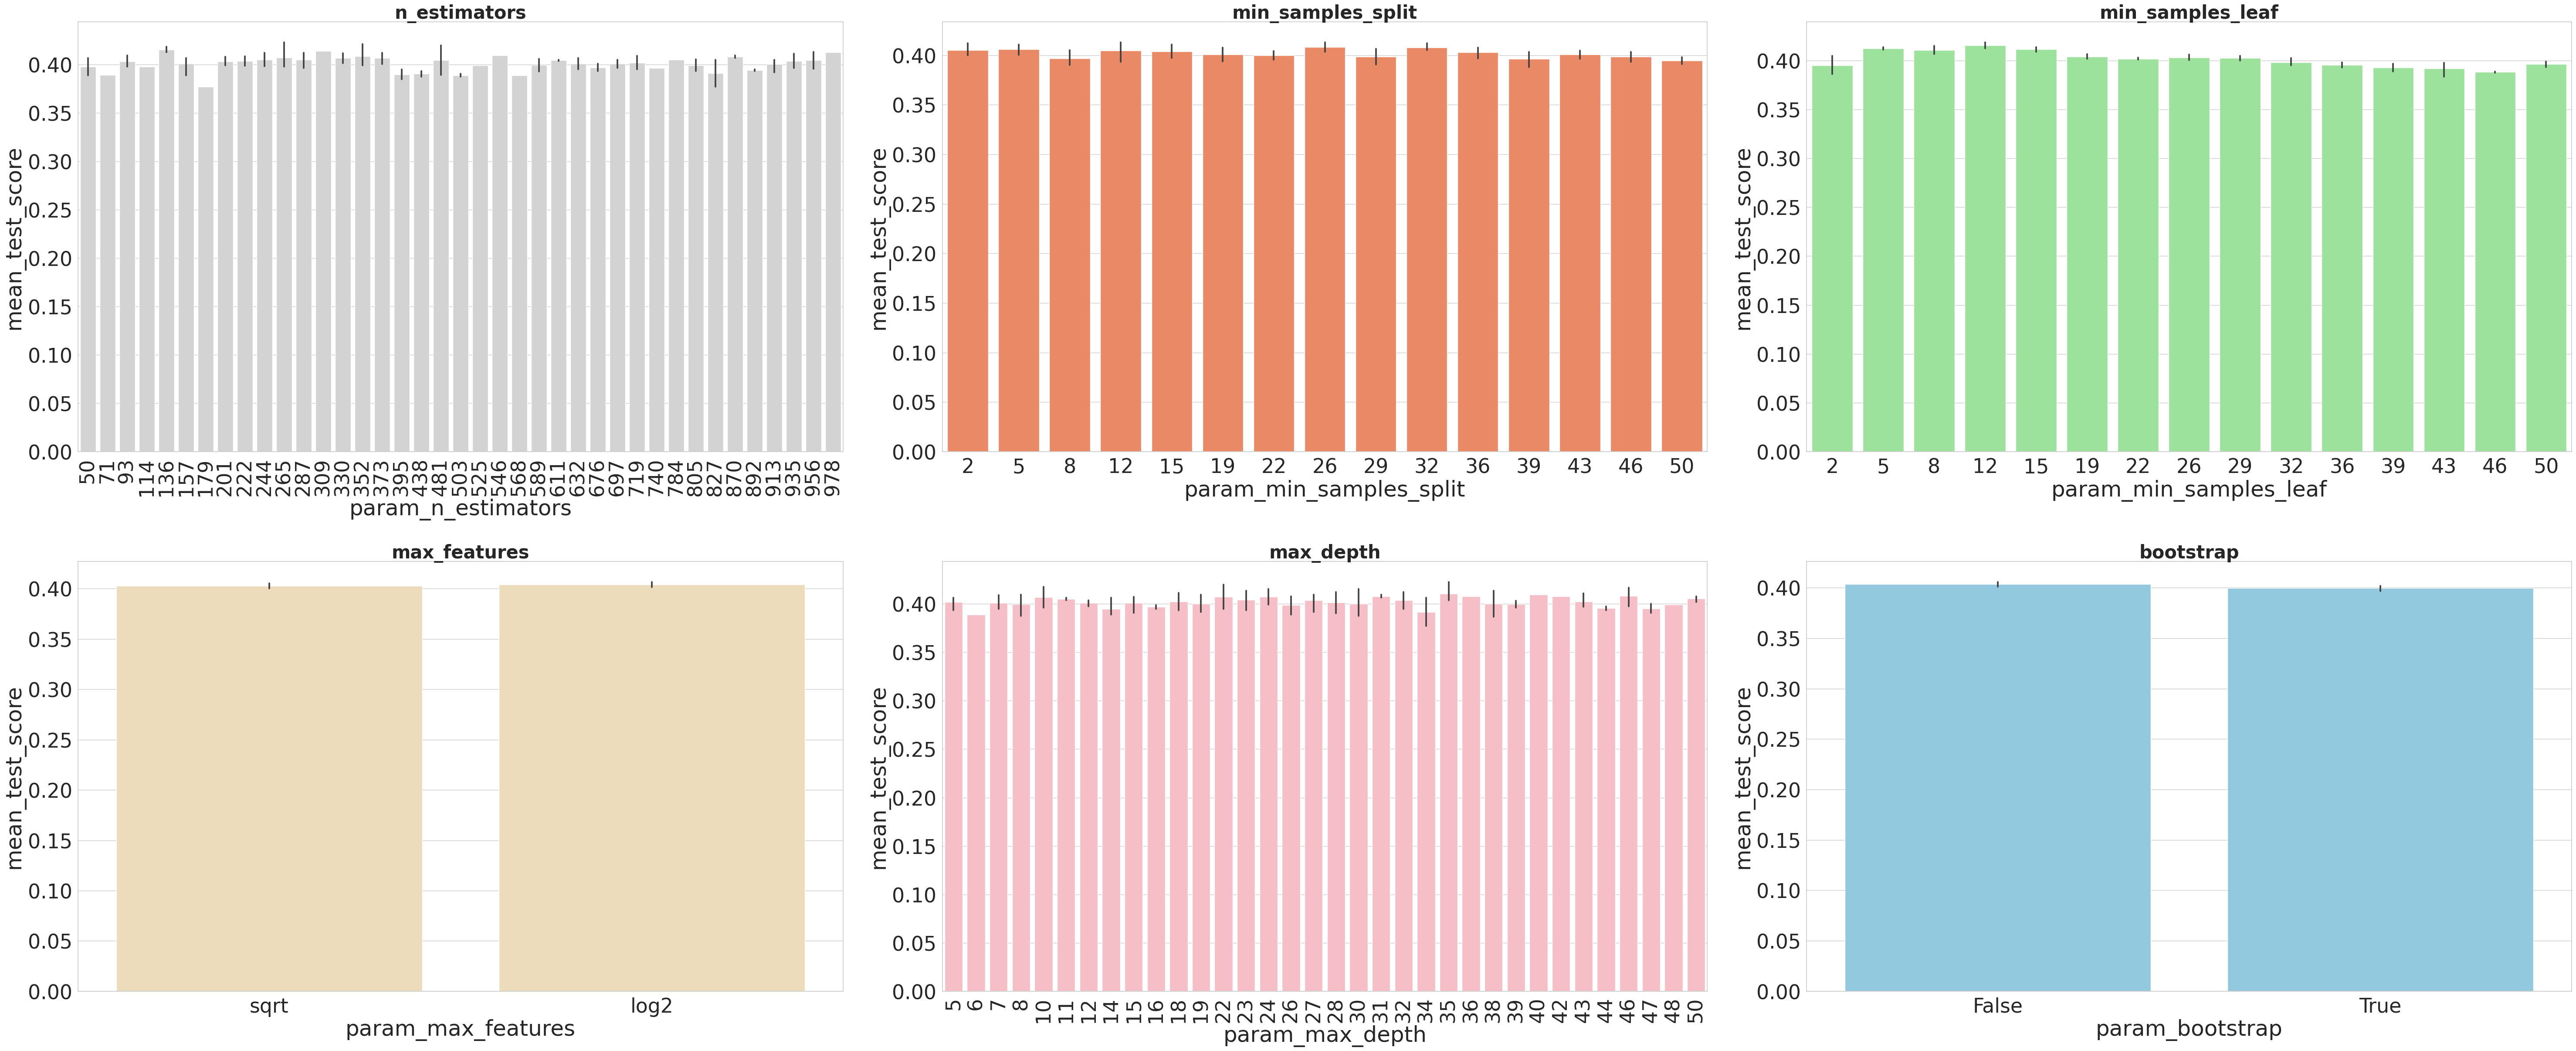

In [68]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale=3)
fig.set_size_inches(60, 25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0, 0], color='lightgrey')
axs[0, 0].set_title(label='n_estimators', size=30, weight='bold')
axs[0, 0].tick_params(axis='x', labelrotation=90)

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0, 1], color='coral')
axs[0, 1].set_title(label='min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0, 2], color='lightgreen')
axs[0, 2].set_title(label='min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1, 0], color='wheat')
axs[1, 0].set_title(label='max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1, 1], color='lightpink')
axs[1, 1].set_title(label='max_depth', size=30, weight='bold')
axs[1, 1].tick_params(axis='x', labelrotation=90)

sns.barplot(x='param_bootstrap', y='mean_test_score', data=rs_df, ax=axs[1, 2], color='skyblue')
axs[1, 2].set_title(label='bootstrap', size=30, weight='bold')

plt.tight_layout()

plt.show()

In [82]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(
    max_features='sqrt', 
    bootstrap=False, 
    random_state=42
)
parameters = {
    'max_depth': range(8, 13),
    'min_samples_leaf': range(6, 8),
    'min_samples_split': range(23, 29),
    'n_estimators': range(143, 148)
    }
grid_search_cf_clf = GridSearchCV(clf, parameters, cv=3, verbose=1, n_jobs=-1)
grid_search_cf_clf.fit(X_train, y_train)
grid_search_cf_clf.best_params_


Fitting 3 folds for each of 300 candidates, totalling 900 fits


{'max_depth': 10,
 'min_samples_leaf': 7,
 'min_samples_split': 25,
 'n_estimators': 147}

In [83]:
best_clf = grid_search_cf_clf.best_estimator_

In [84]:
best_clf.score(X_train, y_train)

0.5051546391752577

In [85]:
y_pred = best_clf.predict(X_test)

In [86]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='micro')
f1

0.45776566757493187

The F1-score isn't high, but it's sufficient for the current purpose.

In [89]:
# Predicting missing values
y_missing = best_clf.predict(X_missing)  # X_missing - data with missing values

# Creating a Series with predicted values and indices of missing places
predicted_values_series = pd.Series(y_missing, index=X_missing.index)

# Filling missing values in the 'age_labels' column with predicted values
clf_features['age_labels'].fillna(predicted_values_series, inplace=True)

In [90]:
clf_features.reset_index(drop=True, inplace=True)
clf_features['age_labels'] = clf_features['age_labels'].astype('int')
clf_features

,Pclass,Family,salutation_labels,embarked_labels,fare_labels,age_labels,is_male
0,3,1,2,2,4,2,1
1,1,1,3,0,0,3,0
2,3,0,1,2,1,2,0
3,1,1,3,2,0,3,0
4,3,0,2,2,1,3,1
...,...,...,...,...,...,...,...
1304,3,0,2,2,1,2,1
1305,1,0,4,0,0,3,0
1306,3,0,2,2,4,3,1
1307,3,0,2,2,1,2,1


# **Modeling**

In [91]:
# Separating the prediction dataset for 'X_pred' using data from index 891 onwards
X_pred = clf_features.iloc[891:, :]

# Separating the training dataset 'X' using data up to index 890
X = clf_features.iloc[:891, :]

# Extracting the target variable 'y' from the 'Survived' column of the Titanic training dataset
y = titanic_train.Survived

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=42)

**Principal Component Analysis**

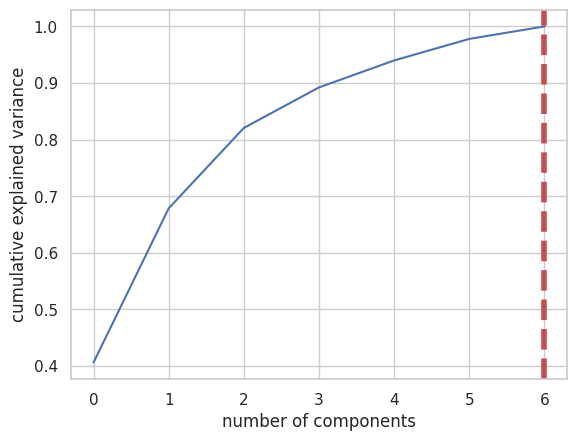

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.41,0.41
1,0.68,0.27
2,0.82,0.14
3,0.89,0.07
4,0.94,0.05
5,0.98,0.04
6,1.00,0.02


In [93]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=7)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

**Tuning Hyperparameters**

Round 1: RandomizedSearchCV

In [94]:
rfc = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=50, stop=1000, num=45)],
    'max_depth': [int(x) for x in np.linspace(start=5, stop=50, num=35)],
    'min_samples_split': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'min_samples_leaf': [int(x) for x in np.linspace(start=2, stop=50, num=15)],
    'max_features': ['log2', 'sqrt', None],
    'bootstrap': [True, False]
}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=42)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 6, 7, 8, 10, 11, 12,
                                                      14, 15, 16, 18, 19, 20,
                                                      22, 23, 24, 26, 27, 28,
                                                      30, 31, 32, 34, 35, 36,
                                                      38, 39, 40, 42, 43, ...],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [2, 5, 8, 12, 15,
                                                             19, 22, 26, 29, 32,
                                                             36, 39, 43, 46,
                                                             50],
                                        'min_samples_split': [2, 5, 8, 12, 15,
                                                              19, 22, 26, 29,
                                                              32, 36, 39, 43,
                                                              46, 50],
                                        'n_estimators': [50, 71, 93, 114, 136,
                                                         157, 179, 201, 222,
                                                         244, 265, 287, 309,
                                                         330, 352, 373, 395,
                                                         417, 438, 460, 481,
                                                         503, 525, 546, 568,
                                                         589, 611, 632, 654,
                                                         676, ...]},
                   random_state=42, verbose=1)

In [95]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)

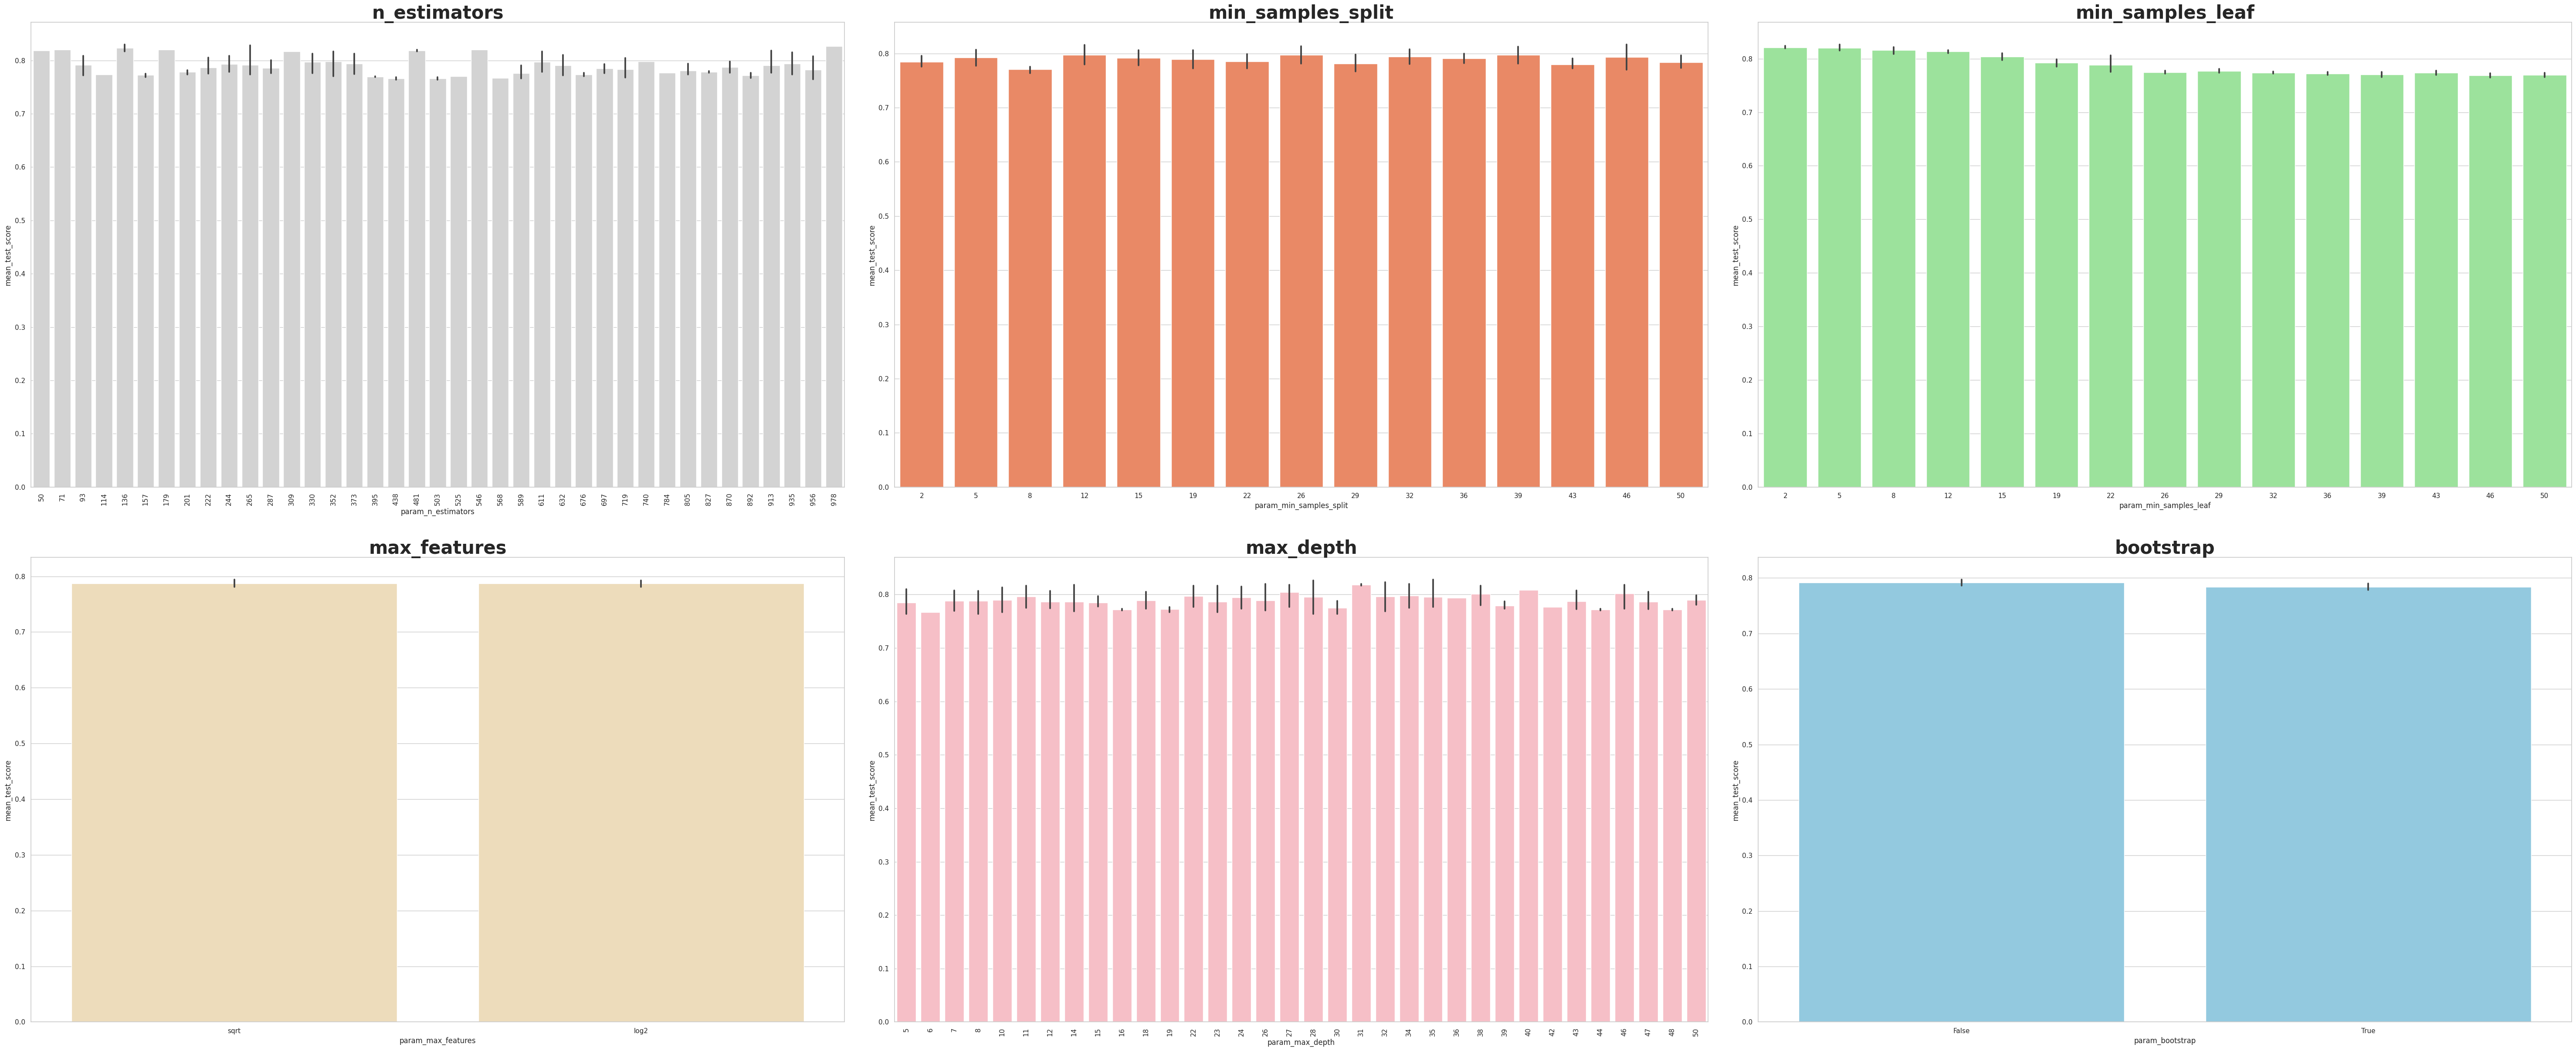

In [96]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale=3)
fig.set_size_inches(60, 25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0, 0], color='lightgrey')
axs[0, 0].set_title(label='n_estimators', size=30, weight='bold')
axs[0, 0].tick_params(axis='x', labelrotation=90)

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0, 1], color='coral')
axs[0, 1].set_title(label='min_samples_split', size=30, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0, 2], color='lightgreen')
axs[0, 2].set_title(label='min_samples_leaf', size=30, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1, 0], color='wheat')
axs[1, 0].set_title(label='max_features', size=30, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1, 1], color='lightpink')
axs[1, 1].set_title(label='max_depth', size=30, weight='bold')
axs[1, 1].tick_params(axis='x', labelrotation=90)

sns.barplot(x='param_bootstrap', y='mean_test_score', data=rs_df, ax=axs[1, 2], color='skyblue')
axs[1, 2].set_title(label='bootstrap', size=30, weight='bold')

plt.tight_layout()

plt.show()

Round 2: GridSearchCV

In [117]:
clf = RandomForestClassifier(
    max_features='sqrt', 
    bootstrap=False, 
    random_state=42
)
parameters = {
    'max_depth': range(10, 15),
    'min_samples_leaf': (2,),
    'min_samples_split': range(33, 39),
    'n_estimators': range(112, 117)
    }
grid_search_cf_clf = GridSearchCV(clf, parameters, cv=3, verbose=1, n_jobs=-1)
grid_search_cf_clf.fit(X_train, y_train)
grid_search_cf_clf.best_params_


Fitting 3 folds for each of 600 candidates, totalling 1800 fits


{'max_depth': 13,
 'min_samples_leaf': 2,
 'min_samples_split': 36,
 'n_estimators': 115}

In [118]:
best_clf = grid_search_cf_clf.best_estimator_
best_clf.score(X_train, y_train)

0.8479338842975207

In [119]:
y_pred = best_clf.predict(X_test)

In [120]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
f1

0.7735849056603773

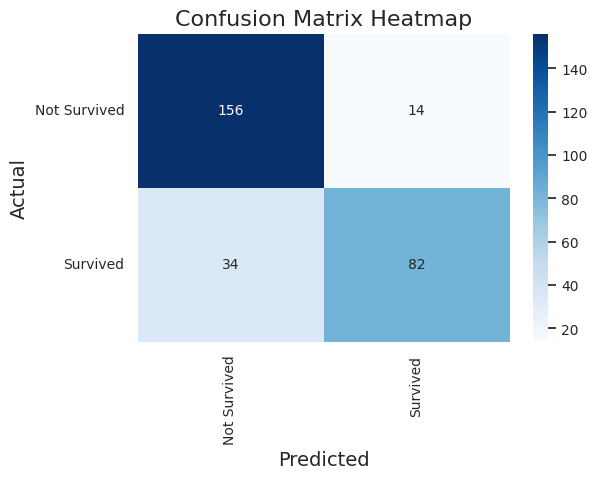

In [121]:
from sklearn.metrics import confusion_matrix

# Creating a confusion matrix using predicted and actual labels
conf_matrix = confusion_matrix(y_test, y_pred)

# Creating a DataFrame from the confusion matrix
df_conf_matrix = pd.DataFrame(conf_matrix, columns=['Not Survived', 'Survived'], 
                              index=['Not Survived', 'Survived'])

# Creating a plot with font size setting for axis labels and title
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df_conf_matrix, annot=True, cmap='Blues', fmt='d', annot_kws={'fontsize': 10})

# Setting font size for tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=10)  # Set desired font size here (10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)  # Set desired font size here (10)

# Accessing the colorbar object and setting its label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=10)  # Set desired font size here (10)

# Setting font size for axis labels and title
plt.xlabel('Predicted', fontsize=14)  # Set desired font size here (14)
plt.ylabel('Actual', fontsize=14)  # Set desired font size here (14)
plt.title('Confusion Matrix Heatmap', fontsize=16)  # Set desired font size here (16)

plt.show()


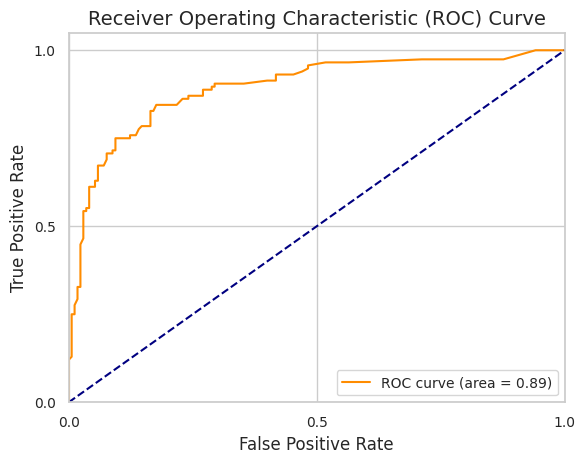

In [125]:
from sklearn.metrics import roc_curve, auc

# Getting probability predictions on the test set
y_predicted_prob = best_clf.predict_proba(X_test)

# Calculating ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [126]:
result = best_clf.predict(X_pred)

In [127]:
submission = pd.DataFrame({'PassengerId': titanic_data.PassengerId[891 :], 'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic_Predictions.csv'
submission.to_csv(filename,index=False)

(418, 2)


In [128]:
submission

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
...,...,...
1304,1305,0
1305,1306,1
1306,1307,0
1307,1308,0
